In [6]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [10]:
import sys
import pathlib

sys.path.append(str(pathlib.Path().cwd().parent))

In [11]:
import pandas as pd
import numpy as np
from keras.models import Sequential
from keras.layers import Dense, Flatten
from keras.layers import Conv1D, MaxPooling1D

In [12]:
from plotting import plot_ts

In [13]:
from dataset import Dataset
dataset = Dataset('../data/dataset/')

### Предсказание одномерного ряда на одну точку вперед

#### Выгрузим одномерный ряд alcohol_sales 

In [ ]:
ts = dataset['alcohol_sales.csv']
ts = (ts - ts.min()) / (ts.max() - ts.min())

<Axes: xlabel='0'>

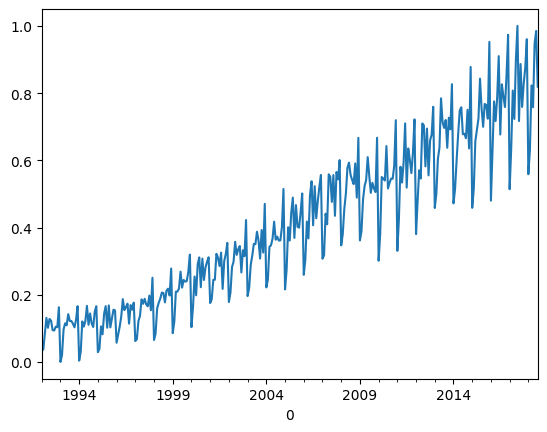

In [181]:
ts.plot()

#### Напишем функцию, которая переводит time series в матрицу обьекты-признаки

In [182]:
def transform_into_matrix(ts: pd.Series, num_lags: int) -> pd.DataFrame:
    """
    Transforms time series into lags matrix to allow
    applying supervised learning algorithms

    Parameters
    ------------
    ts
        Time series to transform
    num_lags
        Number of lags to use

    Returns
    --------
        train, test: np.arrays of shapes (ts-num_lags, num_lags), (num_lags,)
    """

    ts_values = ts.values
    data = {}
    for i in range(num_lags + 1):
        data[f'lag_{num_lags - i}'] = np.roll(ts_values, -i)

    lags_matrix = pd.DataFrame(data)[:-num_lags]
    lags_matrix.index = ts.index[num_lags:]

    return lags_matrix.drop('lag_0', axis=1).values, lags_matrix['lag_0'].values

In [183]:
NUM_LAGS = 24
X, y = transform_into_matrix(ts, NUM_LAGS)

In [184]:
X.shape

(295, 24)

In [185]:
y

array([0.00375779, 0.02954992, 0.120591  , 0.1050474 , 0.12204287,
       0.16688018, 0.11042788, 0.14416261, 0.1146981 , 0.10393714,
       0.1497139 , 0.16568452, 0.02895209, 0.03868819, 0.10573063,
       0.08224443, 0.14382099, 0.16594073, 0.10180203, 0.16816124,
       0.10282689, 0.13007089, 0.15543599, 0.15330088, 0.05705013,
       0.08130498, 0.1051328 , 0.13562217, 0.1868648 , 0.15415492,
       0.16312238, 0.17345632, 0.11392946, 0.1691861 , 0.15535059,
       0.17644547, 0.06208899, 0.06781109, 0.12153045, 0.13698864,
       0.18609617, 0.17302929, 0.18788966, 0.17106499, 0.16559911,
       0.19736954, 0.1537279 , 0.25057648, 0.06533436, 0.08437954,
       0.15945   , 0.17584764, 0.18840208, 0.20633701, 0.20531215,
       0.17729951, 0.2121445 , 0.217952  , 0.19771116, 0.27799129,
       0.08548979, 0.11990776, 0.20906995, 0.20941156, 0.21829362,
       0.26859681, 0.22119737, 0.24408575, 0.23887608, 0.24066957,
       0.26893842, 0.31941242, 0.10351012, 0.16406183, 0.25424

#### Сделаем необходимый reshape к двумерному виду для сверточного слоя и разобьем на train, test 

In [199]:
X = X.reshape((X.shape[0], X.shape[1], 1))

split_idx = int(len(ts) * 0.7)
X_train, y_train = X[:split_idx], y[:split_idx]
X_test, y_test = X[split_idx:], y[split_idx:]

In [200]:
y[0]

0.0037577931505679394

#### Зададим входной сверточный слой модели.

In [201]:
model = Sequential()

In [202]:
### Обратим внимание на то, что для временных рядов используется свертка только в одном направлении по временной
### шкале - поэтому Conv1D
model.add(Conv1D(64, 18, activation='relu', input_shape=(NUM_LAGS, 1)))

#### Добавим Pooling для борьбы с переобучением (наличие/отсутствие пулинга как и выбор его типа опционален и зависит от длины вашего ряда, сложности паттерна и т.д., что влияет на переобучение вашей модели) 

In [203]:
model.add(MaxPooling1D())

#### Добавим слой Flatten для перехода к одномерному формату входных данных для полносвязной сети

In [204]:
model.add(Flatten())

#### Добавим пару промежуточных полносвязных слоев и выходной слой с одним нейроном для предсказания одной точки

In [205]:
# model.add(Dense(64, activation='relu'))
# model.add(Dense(32, activation='relu'))
model.add(Dense(1, activation='relu'))

In [206]:
model.compile(optimizer='adam', loss='mse')

In [207]:
model.fit(X_train, y_train, epochs=100, verbose=0, validation_data=(X_test, y_test))

In [208]:
y_pred = model.predict(X_test).flatten()

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


<Axes: >

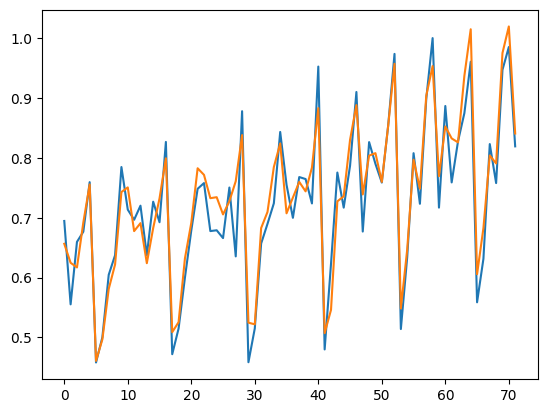

In [209]:
pd.Series(y_test).plot()
pd.Series(y_pred).plot()

### Векторное предсказание для одномерного ряда

Попробуем решить аналогичную предыдущему занятию задачу предсказания вектора следующих точек, но теперь добавим
в модель признаки, сгенерённые сверточным слоем 

#### 1) Возьмем функцию трансформации ряда из прошлого занятия

In [220]:
from typing import Tuple

def transform_ts_into_matrix(ts: pd.Series, num_lags_in: int, num_lags_out: int) -> Tuple[np.array, np.array]:
    """
    Данная функция должна пройтись скользящим окном по временному ряду и для каждых
    num_lags_in точек в качестве признаков собрать num_lags_out следующих точек в качестве таргета.
    
    Вернуть два np.array массива из X_train и y_train соответственно
    """
    sequence = ts.values
    X, y = list(), list()
    i = 0
    outer_idx = num_lags_out
    while outer_idx < len(sequence):
        inner_idx = i + num_lags_in
        outer_idx = inner_idx + num_lags_out
        X_, y_ = sequence[i:inner_idx], sequence[inner_idx:outer_idx]
        X.append(X_)
        y.append(y_)
        i += 1
    return np.array(X), np.array(y)

#### 2) Приведем входные данные к двумерному виду

In [221]:
NUM_LAGS = 24
NUM_OUTPUT = 12
X, y = transform_ts_into_matrix(ts, NUM_LAGS, NUM_OUTPUT)
X = X.reshape((X.shape[0], X.shape[1], 1))

#### 3) Разобьем на трейн и тест, отложив в качестве теста последние 12 точек

In [222]:
X_train, y_train = X[:-1], y[:-1]
X_test, y_test = X[[-1]], y[-1]

In [223]:
X_train.shape

(283, 24, 1)

In [224]:
y_train.shape

(283, 12)

In [225]:
y_test = y_test.reshape((1, 12))

#### 4) Постройте сеть из CNN слоев, соединенных с полносвязными слоями 

In [230]:
model = Sequential()
model.add(Conv1D(64, 23, activation='relu', input_shape=(NUM_LAGS, 1)))
model.add(MaxPooling1D())
model.add(Flatten())
model.add(Dense(NUM_OUTPUT))
model.compile(optimizer='adam', loss='mse')

/Users/technogleb/ts_nov_2024/env/lib/python3.10/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


#### 5) Обучите модель

In [231]:
model.fit(X_train, y_train, epochs=200, validation_data=(X_test, y_test))

Epoch 1/200
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.2522 - val_loss: 0.3784
Epoch 2/200
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.1024 - val_loss: 0.1313
Epoch 3/200
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0315 - val_loss: 0.0438
Epoch 4/200
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0156 - val_loss: 0.0223
Epoch 5/200
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0085 - val_loss: 0.0169
Epoch 6/200
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0080 - val_loss: 0.0145
Epoch 7/200
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0076 - val_loss: 0.0129
Epoch 8/200
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0070 - val_loss: 0.0153
Epoch 9/200
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0068 - val_loss: 0.0136
Epoch 10/200
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0069 - val_loss: 0.0128
Epoch 11/200
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0066 - val_loss: 0.0131
Epoch 12/200
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0064 - val_loss: 0.0127


#### 5) Постройте предсказания (не забудьте вызвать метод flatten в конце предсказания)

In [232]:
y_pred = model.predict(X_test).flatten()

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step


<Axes: >

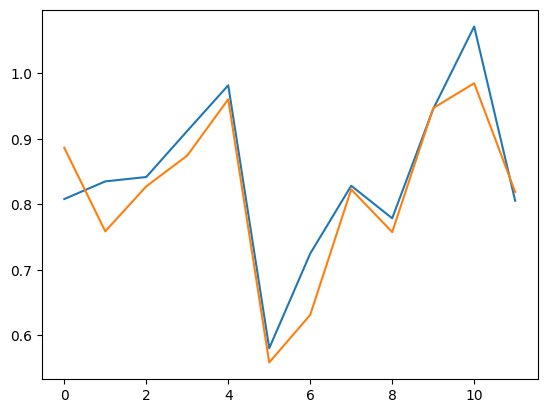

In [233]:
pd.Series(y_pred).plot()
pd.Series(y_test.flatten()).plot()

In [235]:
from sklearn.metrics import mean_absolute_error

#### 6) Постройте предсказание без добавления сверточных слоев и сравните качество

In [237]:
X_train.shape

(283, 24, 1)

In [239]:
X_train = X_train.reshape((283, 24))

In [244]:
X_test = X_test.reshape((1, 24))

In [247]:
model = Sequential()
# model.add(Conv1D(64, 2, activation='relu', input_shape=(NUM_LAGS, 1)))
# model.add(MaxPooling1D())
model.add(Dense(64, activation='relu', input_dim=24))
model.add(Dense(32))
# model.add(Flatten())
model.add(Dense(NUM_OUTPUT))
model.compile(optimizer='adam', loss='mse')

In [248]:
model.fit(X_train, y_train, epochs=100, validation_data=(X_test, y_test))

Epoch 1/100
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.4875 - val_loss: 0.6541
Epoch 2/100
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.1725 - val_loss: 0.2076
Epoch 3/100
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0648 - val_loss: 0.0631
Epoch 4/100
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0264 - val_loss: 0.0258
Epoch 5/100
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0144 - val_loss: 0.0262
Epoch 6/100
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0122 - val_loss: 0.0229
Epoch 7/100
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0110 - val_loss: 0.0146
Epoch 8/100
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0099 - val_loss: 0.0143
Epoch 9/100
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0095 - val_loss: 0.0119
Epoch 10/100
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0096 - val_loss: 0.0123
Epoch 11/100
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0090 - val_loss: 0.0131
Epoch 12/100
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0088 - val_loss: 0.0114
E

In [249]:
y_pred = model.predict(X_test).flatten()

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


In [250]:
y_test

array([[0.88658297, 0.75890341, 0.82756854, 0.87462636, 0.96054317,
        0.55863011, 0.63130925, 0.8229567 , 0.75779315, 0.94704928,
        0.98505423, 0.8191135 ]])

<Axes: >

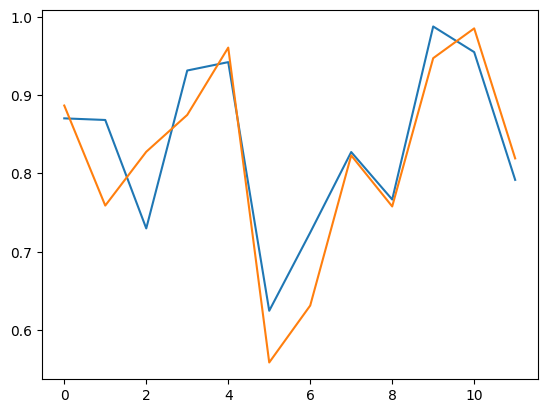

In [251]:
pd.Series(y_pred).plot()
pd.Series(y_test.flatten()).plot()

### Предсказание многомерного ряда

Где применение CNN вызывает наибольший интерес, так это в многомерных рядах или рядах с наличием экзогенных признаков, так как позволяет автоматически генерировать большое количество признаков из коррелирующих рядов.

В данном примере мы будем предсказывать каждую компоненту многомерного временного ряда, используя данные из всех компонент, т.е. каждая компонента будет в качестве признаков лаги всех соседних рядов, а CNN будет вычленять из них произвольные признаки.

In [253]:
ts = pd.read_csv('../data/stability_index.csv', index_col='timestamp', parse_dates=True)

In [254]:
ts.head()

,1,2,3,4,5,6,7,8,9
timestamp,,,,,,,,,
2020-01-15 13:00:00,205.0,92.0,63.0,55.0,26.0,27.0,20.0,34.0,155.0
2020-01-15 14:00:00,173.0,97.0,69.0,44.0,31.0,22.0,41.0,26.0,182.0
2020-01-15 15:00:00,145.0,83.0,73.0,58.0,40.0,25.0,31.0,19.0,167.0
2020-01-15 16:00:00,84.0,60.0,53.0,39.0,32.0,31.0,19.0,15.0,102.0
2020-01-15 17:00:00,117.0,77.0,40.0,53.0,33.0,29.0,21.0,30.0,160.0


In [257]:
ts = ts.apply(lambda x: (x - x.min()) / (x.max() - x.min()), axis=0)

<Axes: xlabel='timestamp'>

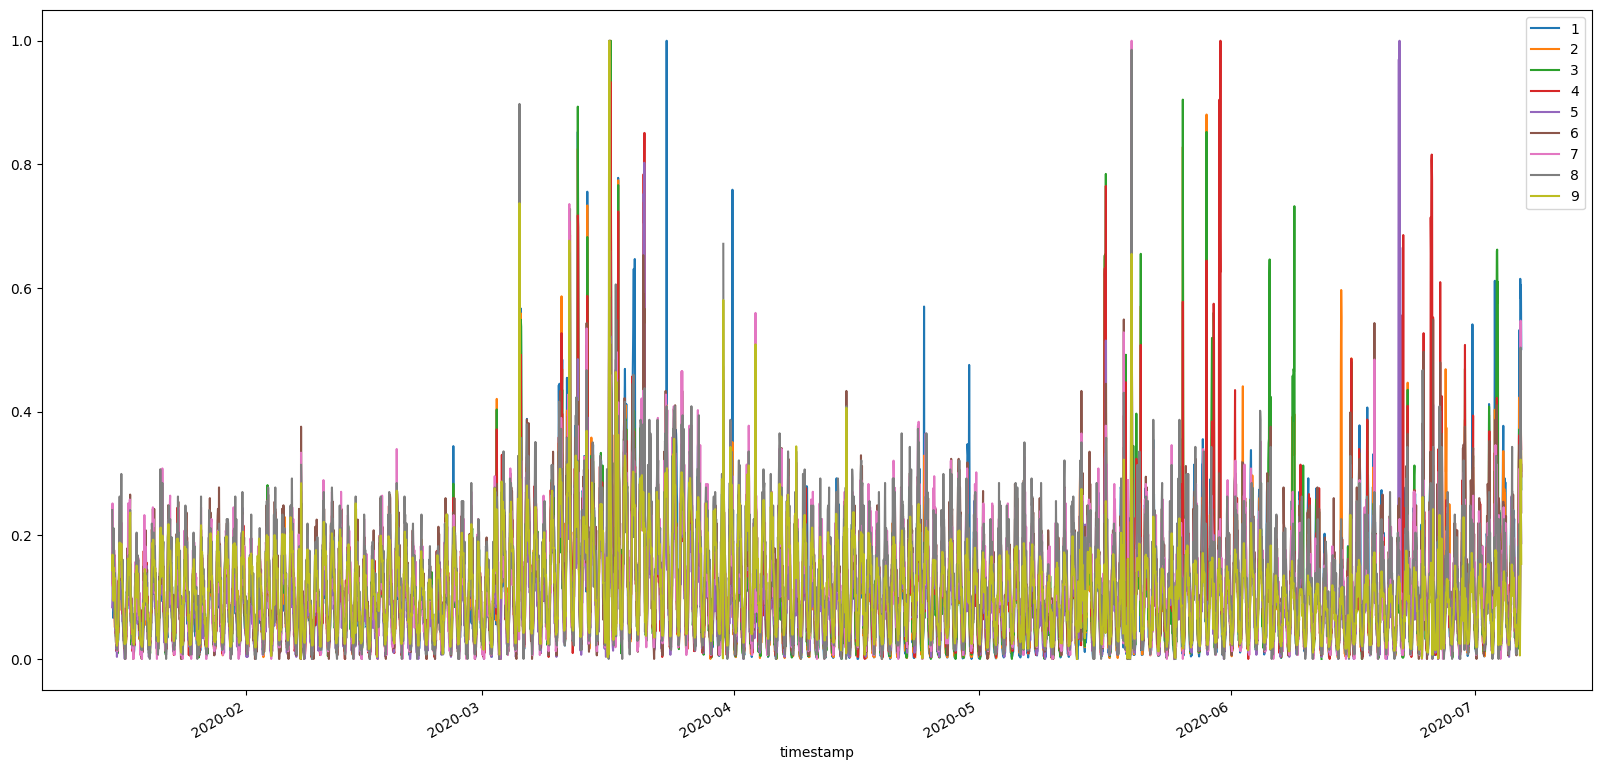

In [258]:
ts.plot(figsize=(20, 10))

In [259]:
import math

from pandas._libs.tslibs.timestamps import Timestamp


def get_month_sin(timestamp: Timestamp) -> float:
    theta = timestamp.month * (2*math.pi / 12)
    return math.sin(theta)


def get_month_cos(timestamp: Timestamp) -> float:
    theta = timestamp.month * (2*math.pi / 12)
    return math.cos(theta)


def get_day_sin(timestamp: Timestamp) -> float:
    theta = timestamp.day * (2*math.pi / timestamp.days_in_month)
    return math.sin(theta)


def get_day_cos(timestamp: Timestamp) -> float:
    theta = timestamp.day * (2*math.pi / timestamp.days_in_month)
    return math.cos(theta)


def get_dayofweek_sin(timestamp: Timestamp) -> float:
    theta = timestamp.dayofweek * (2*math.pi / 7)
    return math.sin(theta)


def get_dayofweek_cos(timestamp: Timestamp) -> float:
    theta = timestamp.dayofweek * (2*math.pi / 7)
    return math.cos(theta)


def get_hour_sin(timestamp: Timestamp) -> float:
    theta = timestamp.hour * (2*math.pi / 24)
    return math.sin(theta)


def get_hour_cos(timestamp: Timestamp) -> float:
    theta = timestamp.hour * (2*math.pi / 24)
    return math.cos(theta)


def get_minute_sin(timestamp: Timestamp) -> float:
    theta = timestamp.minute * (2*math.pi / 60)
    return math.sin(theta)


def get_minute_cos(timestamp: Timestamp) -> float:
    theta = timestamp.minute * (2*math.pi / 60)
    return math.cos(theta)


datetime_mappers = {
    'month_sin': get_month_sin,
    'month_cos': get_month_cos,
    'day_sin': get_day_sin,
    'day_cos': get_day_cos,
    'dayofweek_sin': get_dayofweek_sin,
    'dayofweek_cos': get_dayofweek_cos,
    'hour_sin': get_hour_sin,
    'hour_cos': get_hour_cos,
    'minute_sin': get_minute_sin,
    'minute_cos': get_minute_cos,
}

In [260]:
ts.fillna(ts.median(), inplace=True)

#### 1) Возьмем функцию из предыдущего занятия (исключая метод flaten в конце, так как CNN принимает как раз 2D данные)

In [358]:
def transform_multi_ts_into_matrix(ts: pd.DataFrame, num_lags: int):
    """
    Данная функция должна пройтись скользящим окном по временному ряду
    и собрать в качестве признаков X np.array размерности (len(ts)-num_lags, n_dims, num_lags),
    а в качестве y np.array размерности (len(ts)-num_lags, n_dims),
    где n_dims - размерность многомерного ряда.
    
    То есть для всех компонент временного ряда мы должны взять num_lags предыдущих точек каждой компонент
    в качестве признаков и все компоненты текущей точки в качестве target
    """
    sequence = ts.values
    X, y = list(), list()
    i = 0
    end_i = num_lags
    while end_i < len(sequence): 
        seq_x, seq_y = sequence[i:end_i], sequence[end_i]
        X.append(seq_x)
        y.append(seq_y)
        i += 1
        end_i = i + num_lags
    return np.array(X), np.array(y)

In [359]:
NUM_LAGS = 192
NUM_DIMS = ts.shape[1]

In [360]:
X, y = transform_multi_ts_into_matrix(ts, NUM_LAGS)

In [361]:
# Видим, что в качестве обьекта мы получаем матрицу, где количество строк равно количеству компонент нашего ряда
# а количество столбцов количеству лагов, которое мы берем для каждой из компонент
X[0].shape

(192, 9)

In [362]:
y[0].shape

(9,)

In [363]:
X.shape

(3953, 192, 9)

#### 2) Разбейте на train/test

In [364]:
X_train, y_train = X[:-24], y[:-24]
X_test, y_test = X[-24:], y[-24:]

#### 3) Постройте сеть, со сверточным слоем и несколькими полносвязными в конце (подумайте какой shape входных и выходных данных должен быть у первого и последнего слоя)

In [365]:
model = Sequential()
model.add(Conv1D(24, 4, activation='relu', input_shape=(192, 9)))
model.add(MaxPooling1D())
model.add(Flatten())
model.add(Dense(9))
model.compile(optimizer='adam', loss='mse')


/Users/technogleb/ts_nov_2024/env/lib/python3.10/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


#### 4) Обучите модель

In [366]:
model.fit(X_train, y_train, epochs=100, validation_data=(X_test, y_test))

Epoch 1/100
123/123 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0079 - val_loss: 0.0107
Epoch 2/100
123/123 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0032 - val_loss: 0.0087
Epoch 3/100
123/123 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0030 - val_loss: 0.0088
Epoch 4/100
123/123 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0027 - val_loss: 0.0085
Epoch 5/100
123/123 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0027 - val_loss: 0.0082
Epoch 6/100
123/123 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0024 - val_loss: 0.0082
Epoch 7/100
123/123 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0024 - val_loss: 0.0081
Epoch 8/100
123/123 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0020 - val_loss: 0.0082
Epoch 9/100
123/123 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0020 - val_loss: 0.0080
Epoch 10/100
123/123 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0019 - val_loss: 0.0076
Epoch 11/100
123/123 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0019 - val_loss: 0.0081
Epoch 12/100
123/123 ━━━━━━━━━━━━━━━━━━━━

#### 5) Сделайте предсказание на тесте

In [367]:
y_pred = model.predict(X_test)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step


<Axes: >

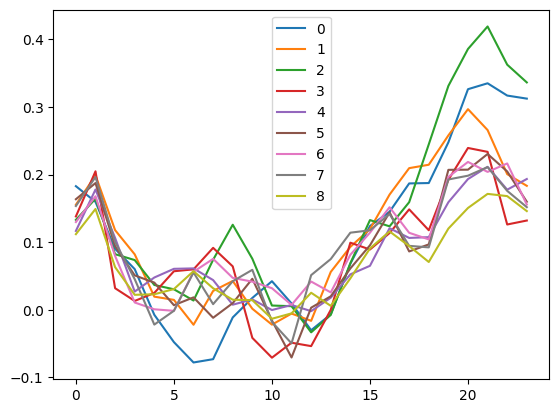

In [368]:
pd.DataFrame(y_pred).plot()

<Axes: >

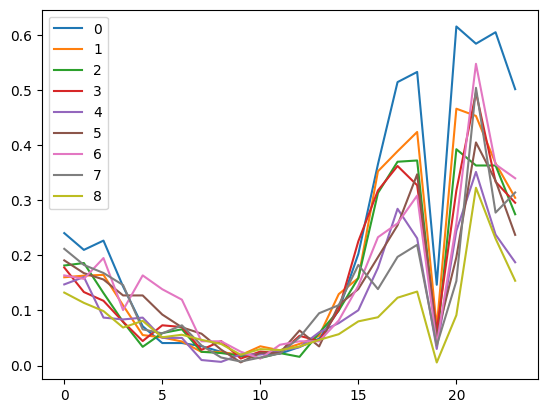

In [369]:
pd.DataFrame(y_test).plot()

In [370]:
plot_ts(pd.Series(y_test[:, 1]), pd.Series(y_pred[:, 1]))

Loading BokehJS ...

In [371]:
X_train, y_train = X[:-24], y[:-24]
X_test, y_test = X[-24:], y[-24:]

#### 6) Сравните полученые предсказания с предсказанием каждой компоненты как отдельного ряда при помощи TimeSeriesPredictor

* Разбейте ряд на 9 одномерных рядов
* Обучите модель TimeSeriesPredictor
* Сделайте батч предсказание на длину X_test
* сравните результаты с CNN

In [372]:
def train_test_split(ts: pd.Series, ratio: float = 0.7) -> Tuple[pd.Series]:
    split_idx = 24
    ts_train, ts_test = ts[:-split_idx], ts[-split_idx:]
    # ваш код здесь
    return ts_train, ts_test

In [373]:
def make_pipeline(
    ts: pd.Series,
    granularity: str,
    model: callable,
    num_lags=24,
    use_mappers=True,
    **kwargs
) -> Tuple[pd.Series]:
    
    train, test = train_test_split(ts)
    
    predictor = TimeSeriesPredictor(
        granularity=granularity,
        num_lags=num_lags,
        model=model,
    )
    
    if use_mappers:
        predictor.set_params(mappers=datetime_mappers)
        
    predictor.set_params(**kwargs)
    predictor.fit(train)
    
    in_sample = predictor.predict_batch(train, test)
    out_of_sample = predictor.predict_next(train, len(test))
    
   
    out_of_sample.index = test.index
    
    return train, test, in_sample, out_of_sample

In [374]:
from model import TimeSeriesPredictor

In [378]:
ts_0 = ts['1']

In [379]:
ts_0.fillna(0,inplace=True)

In [380]:
from sklearn.linear_model import LinearRegression
granularity = 'PT1H'
model = LinearRegression
num_lags = 24
params = {}
train, test, in_sample, out_of_sample = make_pipeline(ts_0, granularity, model, num_lags, use_mappers=True, **params)

In [381]:
plot_ts(train, test, out_of_sample)

Loading BokehJS ...

#### 7) Сделайте то же самое, что и в 6 пункте, но теперь добавьте в качестве признаков для каждого одномерного ряда лаги от всех остальных 8 рядов. Получился ли результат лучше чем CNN?

In [43]:
# ваш код здесь